<a href="https://colab.research.google.com/github/atharvara/projectEDI/blob/main/T_L_I_S_EDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.4.0+cpu which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.

In [ ]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [ ]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [ ]:
class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)
        # return fused_img

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output
        
        
    def _RGB_to_YCbCr(self, img_RGB):
            """
            A private method which converts an RGB image to YCrCb format
            """
            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
            """
            A private method which converts a YCrCb image to RGB format
            """
            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
            """
            A private method which returns True if image is gray, otherwise False
            """
            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):
            """
            A private method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            A private method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input)) 


In [ ]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

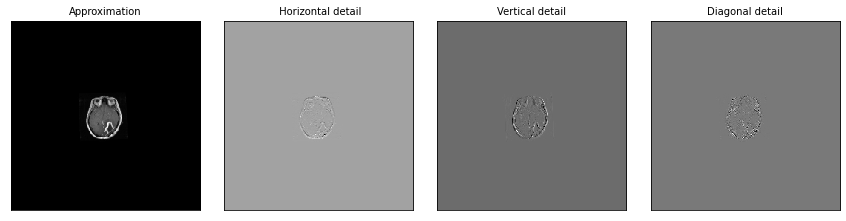

In [ ]:
mri_image = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/mri_registered.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/mri_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

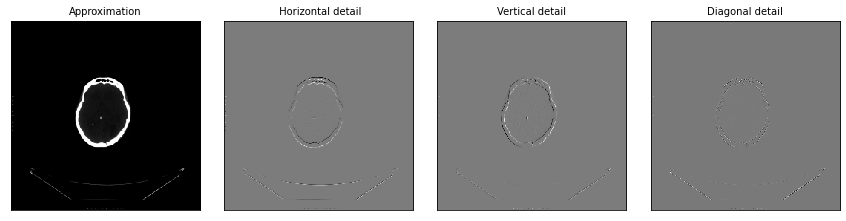

In [ ]:
ct_image = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/ct.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/ct_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
input_images = []
mri = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/mri_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/ct_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_0.jpg', fusion_img)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

True

In [ ]:
input_images = []
mri = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/mri_1.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/ct_1.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_1.jpg', fusion_img)

True

In [ ]:
input_images = []
mri = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/mri_2.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/ct_2.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_2.jpg', fusion_img)

True

In [ ]:

input_images = []
mri = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/mri_3.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/ct_3.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_3.jpg', fusion_img)

True

In [ ]:
fusion_0 = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_0.jpg')
fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

fusion_1 = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_1.jpg')
fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

fusion_2 = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_2.jpg')
fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

fusion_3 = cv2.imread('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/fusion_3.jpg')
fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))

In [ ]:
fusion=pywt.idwt2(coeffs,'haar')
cv2.imwrite('/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/final_fusion.jpg',fusion)

True

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater


ImportError: ignored

In [10]:
!python -m pip install scikit-image



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

In [14]:
def ShowImage(title,img,ctype):
    plt.figure(figsize=(10, 10))
    if ctype=='bgr':
        b,g,r = cv2.split(img)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        plt.imshow(rgb_img)
    elif ctype=='hsv':
        rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
        plt.imshow(rgb)
    elif ctype=='gray':
        plt.imshow(img,cmap='gray')
    elif ctype=='rgb':
        plt.imshow(img)
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()

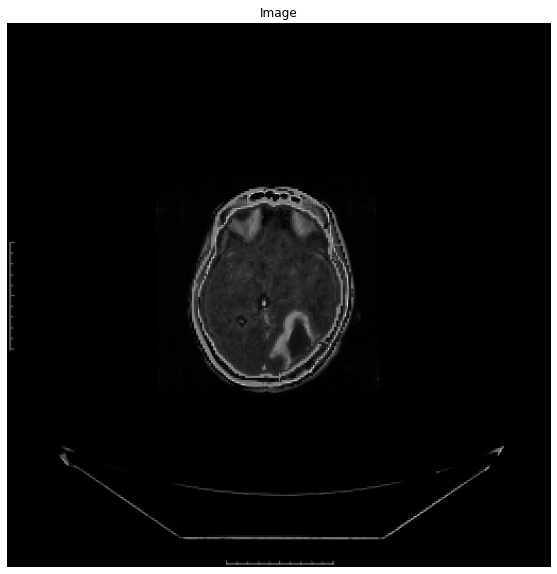

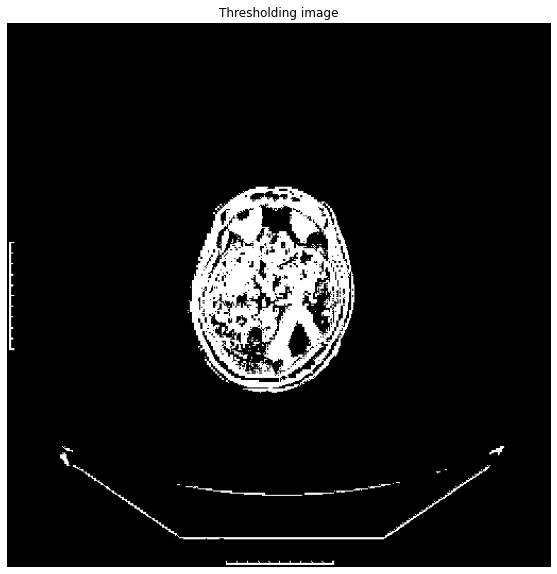

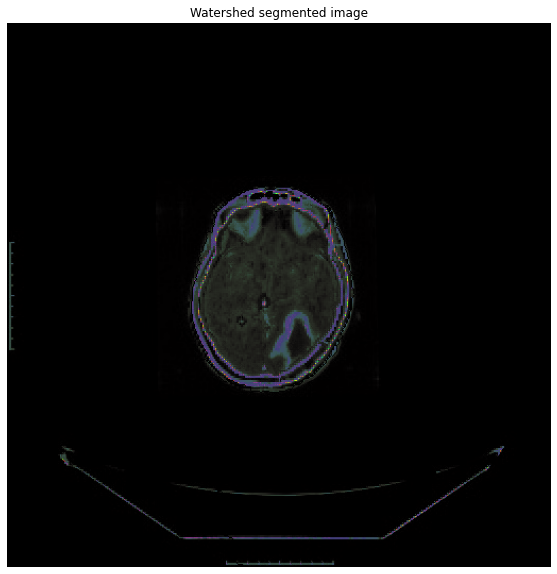

In [15]:
img = cv2.imread("/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/final_fusion.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Image',gray,'gray')

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Thresholding image',thresh,'gray')

ret, markers = cv2.connectedComponents(thresh)

marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
brain_mask = markers==largest_component

brain_out = img.copy()
brain_out[brain_mask==False] = (0,0,0)

img = cv2.imread("/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/final_fusion.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
save_to_path="/content/drive/MyDrive/31-Atharva Rathi/EDI 23/multimodal-image-fusion-to-detect-brain-tumors-master/python scripts/jpg/segmented.jpg"
cv2.imwrite(save_to_path, im1)
ShowImage('Watershed segmented image',im1,'gray')